In [3]:
import pandas as pd
import numpy as np
from fastai.tabular import *
from imblearn.over_sampling import RandomOverSampler, SMOTENC
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(10)
import warnings
warnings.filterwarnings("ignore")

#Single model classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

#Ensemble classifications models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,confusion_matrix, classification_report, roc_auc_score,
f1_score, recall_score, precision_score, SCORERS)
import time

# Imbalance, Hyperparameter tunning and pipelines
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [4]:
def distbox_plot(data):
    '''Function to plot a seaborn distribution plot 
        with a box plot on top.
        Reference: https://python-graph-gallery.com/24-histogram-with-a-boxplot-on-top-seaborn/'''
    # Cut the window in 2 parts
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(14,4),gridspec_kw={"height_ratios": (.15, .85)})
    # Add a graph in each part
    sns.boxplot(data, ax=ax_box)
    sns.distplot(data, ax=ax_hist)
    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    #Print describtive statistics
    print(data.describe())

def baseline_models(data=[], verbose=False):
    #List of models to be used
    models=[DecisionTreeClassifier(),LogisticRegression(),
            RandomForestClassifier(),GradientBoostingClassifier()]
    #Create training and testing data sets depending on wheather or not they have been generated previously.
    if len(data)== 2:
        X_train, X_test, y_train, y_test = train_test_split(data[0],data[1],random_state=123)
    else:
        X_train, X_test, y_train, y_test = data[0],data[1],data[2],data[3]
    #Instantiate lists to store each of the models results
    accuracy = []
    f1 = []
    auc = []
    recall = []
    precision = []
    #Run thorugh each of the models to get their performance metrics
    for model in models:
        clf = model
        clf.fit(X_train, y_train)
        test_preds = clf.predict(X_test)
        f1.append(f1_score(y_test, test_preds))
        accuracy.append(accuracy_score(y_test, test_preds))
        auc.append(roc_auc_score(y_test, test_preds))
        recall.append(recall_score(y_test, test_preds))
        precision.append(precision_score(y_test, test_preds))
        #Print the model and its report
        if verbose:
            print('Classification Model: ',model,'\n')
            print(classification_report(y_test, test_preds),'\n')
    #store results in dataframe
    results = pd.DataFrame([f1,auc, accuracy, precision,recall],
                      index= ['f1','roc_auc','accuracy','precision','recall',],
                           columns=['DecisionTree','LogisticRegression','RandomForest','Gradient Boosting'])
    #Change orientation of the dataframe
    return results.transpose()

def plot_feat_importance(clf,index):
    '''Plot the 0 most important features for a classifier model in a bar chart
    according to importance'''
    feat_importances = pd.DataFrame(clf.feature_importances_, index=index, columns=['Score'])
    feat_importances = feat_importances.sort_values(by='Score',ascending=True).tail(15)
    feat_importances.plot(kind='barh', title='Top 10 Important Features',legend=False)
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show();
    
def heatmap(data,figsize=(8,8), annot=False):
    #plot heatmap to find multicollinearity
    plt.figure(figsize=figsize)
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
    sns.heatmap(data.corr(),vmin=-0.75,vmax=0.75,center=0, cmap=cmap,annot=annot);

def grid_pipe(pipedict, hyperdict, scoring='f1', display=True):
    model_scores=[]
    fitted_models={}
    for name, pipeline in pipedict.items():
    # Construct grid search
        model = GridSearchCV(estimator=pipeline,
                             param_grid=hyperdict[name],
                             scoring=scoring,
                             cv=5, verbose=2, n_jobs=-1, return_train_score = True)

        # Fit using grid search
        start = time.time()
        model.fit(X_trainres, y_trainres)
        end = time.time()
        #Append socres and time
        model_scores.append((name,model.best_score_,end-start))
        #Append model
        fitted_models[name]=model
        if display:
            #Print when the model has been fitted
            print(f'The {name} model has been fitted.')
            # Best accuracy
            print('Best accuracy: %.3f' % model.best_score_)
            # Best params
            print('Best params:\n', model.best_params_,'\n')
    
    return model_scores, fitted_models

In [5]:
  
# -*- coding: utf-8 -*-
"""
plot a pretty confusion matrix with seaborn
Created on Mon Jun 25 14:17:37 2018
@author: Wagner Cipriano - wagnerbhbr - gmail - CEFETMG / MMC
REFerences:
  https://www.mathworks.com/help/nnet/ref/plotconfusion.html
  https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
  https://stackoverflow.com/questions/5821125/how-to-plot-confusion-matrix-with-string-axis-rather-than-integer-in-python
  https://www.programcreek.com/python/example/96197/seaborn.heatmap
  https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/31720054
  http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
"""

#imports
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sn


def get_new_fig(fn, figsize=[9,9]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1
#

def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='k', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, .1]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, .1]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')
#

def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=11,
      lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sn.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix')
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  #set layout slim
    plt.show()
#

def plot_confusion_matrix_from_data(y_test, predictions, columns=None, annot=True, cmap="Oranges",
      fmt='.2f', fz=11, lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='lin'):
    """
        plot confusion matrix function with y_test (actual values) and predictions (predic),
        whitout a confusion matrix yet
    """
    from sklearn.metrics import confusion_matrix
    from pandas import DataFrame

    #data
    if(not columns):
        #labels axis integer:
        ##columns = range(1, len(np.unique(y_test))+1)
        #labels axis string:
        from string import ascii_uppercase
        columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]

    confm = confusion_matrix(y_test, predictions)
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pretty_plot_confusion_matrix(df_cm, fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis)

In [6]:
train= pd.read_csv('train.csv')
test= pd.read_csv('test.csv')
sampleSubmission= pd.read_csv('sample_submission2.csv')

In [7]:
#Look for missing values.
train.isna().any()

EmployeeNo                             False
Division                               False
Qualification                           True
Gender                                 False
Channel_of_Recruitment                 False
Trainings_Attended                     False
Year_of_birth                          False
Last_performance_score                 False
Year_of_recruitment                    False
Targets_met                            False
Previous_Award                         False
Training_score_average                 False
State_Of_Origin                        False
Foreign_schooled                       False
Marital_Status                         False
Past_Disciplinary_Action               False
Previous_IntraDepartmental_Movement    False
No_of_previous_employers               False
Promoted_or_Not                        False
dtype: bool

In [9]:
#Look for missing values.
test.isna().any()

EmployeeNo                             False
Division                               False
Qualification                           True
Gender                                 False
Channel_of_Recruitment                 False
Trainings_Attended                     False
Year_of_birth                          False
Last_performance_score                 False
Year_of_recruitment                    False
Targets_met                            False
Previous_Award                         False
Training_score_average                 False
State_Of_Origin                        False
Foreign_schooled                       False
Marital_Status                         False
Past_Disciplinary_Action               False
Previous_IntraDepartmental_Movement    False
No_of_previous_employers               False
dtype: bool

It's obvious that the Qualification feature has some missing values in both the train and set dataset

In [10]:
test_id = test['EmployeeNo'] 

In [11]:
pd.set_option('display.max_columns', None)

In [12]:
#Merge both train and test data
df = train.append(test, sort=False, ignore_index=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 19 columns):
EmployeeNo                             54808 non-null object
Division                               54808 non-null object
Qualification                          52399 non-null object
Gender                                 54808 non-null object
Channel_of_Recruitment                 54808 non-null object
Trainings_Attended                     54808 non-null int64
Year_of_birth                          54808 non-null int64
Last_performance_score                 54808 non-null float64
Year_of_recruitment                    54808 non-null int64
Targets_met                            54808 non-null int64
Previous_Award                         54808 non-null int64
Training_score_average                 54808 non-null int64
State_Of_Origin                        54808 non-null object
Foreign_schooled                       54808 non-null object
Marital_Status                         548

## Feature ENgineering

In [14]:
df.Qualification.replace(np.nan,'Null', inplace=True)

In [15]:
l = df.Qualification.tolist()
k=[]
df['is_Qualification_na']=0
k=df['is_Qualification_na'].tolist()

In [16]:
l[54807]

'First Degree or HND'

In [17]:
for i in range(54808):
    if (l[i] == 'Null'):
        k[i] = 1 
    else:
        k[i] = 0 
            
        


In [18]:
k[22]

1

North Central
Benue, Kogi, Kwara, Nassarawa, Niger, Plateau, FCT

North East
Adamawa, Bauchi, Borno, Gombe, Taraba, Yobe

North West
Jigawa, Kaduna, Kano, Katsina, Kebbi, Sokoto,Zamfara

South East
Abia, Anambra, Ebonyi, Enugu Imo

South South
Akwa-Ibom, Bayelsa, Cross-River, Delta, Edo Rivers 

South West
Ekiti, Lagos, Ogun, Ondo, Osun Oyo

In [19]:
df['is_Qualification_na']=k
df['is_Qualification_na'].count()
df['is_Qualification_na'].value_counts()

0    52399
1     2409
Name: is_Qualification_na, dtype: int64

In [20]:
df.Qualification.replace('Null','Non-University Education', inplace=True)

In [21]:
#df.Qualification.iloc[22]
df.Qualification.value_counts()

First Degree or HND         36669
MSc, MBA and PhD            14925
Non-University Education     3214
Name: Qualification, dtype: int64

In [22]:
state=[]
geoZones=[2]
state = df.State_Of_Origin.tolist()

In [23]:
df['geoZones']=0
geoZones = df['geoZones'].tolist()

In [24]:
NorthCentral=['benue', 'kogi', 'kwara', 'nassarawa', 'niger', 'plateau', 'fct']
NorthEast = ['adamawa', 'bauchi', 'borno', 'gombe', 'taraba', 'yobe']
NorthWest =['jigawa', 'kaduna', 'kano', 'katsina', 'kebbi', 'sokoto','zamfara']
SouthEast =['abia', 'anambra', 'ebonyi', 'enugu', 'imo']
SouthSouth =['akwa ibom', 'bayelsa', 'cross river', 'delta', 'edo', 'rivers']
SouthWest =['ekiti', 'lagos', 'ogun', 'ondo', 'osun', 'oyo']

In [25]:
for i in range(df.State_Of_Origin.count()):
    state[i] = state[i].lower()
    

In [26]:
df.State_Of_Origin=state


In [27]:
df.State_Of_Origin.nunique()

37

In [28]:
for i in range(df.State_Of_Origin.count()):
    if (state[i] in NorthCentral):
        geoZones[i] = 'NorthCentral'
    elif (state[i] in NorthEast):
        geoZones[i] = 'NorthEast'
    elif (state[i] in NorthWest):
        geoZones[i] = 'NorthWest'
    elif (state[i] in SouthEast):
        geoZones[i] = 'SouthEast'
    elif (state[i] in SouthSouth):
        geoZones[i] = 'SouthSouth'
    elif (state[i] in SouthWest):
        geoZones[i] = 'SouthWest'

In [29]:
df['geoZones'] = geoZones

In [30]:
df.geoZones.unique()

array(['SouthEast', 'NorthWest', 'NorthCentral', 'SouthSouth', 'SouthWest', 'NorthEast'], dtype=object)

In [31]:
df['employedAge'] = df.Year_of_recruitment - df.Year_of_birth

train = df.iloc[0:38312]
test = df.iloc[38312:]

train.Promoted_or_Not=train.Promoted_or_Not.astype(int)
target = train.Promoted_or_Not
#test = test.drop(['Promoted_or_Not'], axis = 1)

In [32]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16496 entries, 38312 to 54807
Data columns (total 22 columns):
EmployeeNo                             16496 non-null object
Division                               16496 non-null object
Qualification                          16496 non-null object
Gender                                 16496 non-null object
Channel_of_Recruitment                 16496 non-null object
Trainings_Attended                     16496 non-null int64
Year_of_birth                          16496 non-null int64
Last_performance_score                 16496 non-null float64
Year_of_recruitment                    16496 non-null int64
Targets_met                            16496 non-null int64
Previous_Award                         16496 non-null int64
Training_score_average                 16496 non-null int64
State_Of_Origin                        16496 non-null object
Foreign_schooled                       16496 non-null object
Marital_Status                        

In [33]:
#path = untar_data(train)

path = Path('Users/ANTHONY-PC/01workspace/dsn Challenge')

In [34]:
df = df.drop(['EmployeeNo'], axis = 1)

In [35]:
df.Last_performance_score.nunique()

6

In [36]:
data= df.copy()

Now I will look at the non-numerical variables in the dataset.

In [37]:
#Get non-numerical features.
non_num_cols = list(set(data.columns) - set(data.describe().columns))
print('Non-numerical features: ',non_num_cols)

Non-numerical features:  ['geoZones', 'Past_Disciplinary_Action', 'Qualification', 'Division', 'No_of_previous_employers', 'State_Of_Origin', 'Previous_IntraDepartmental_Movement', 'Gender', 'Marital_Status', 'Channel_of_Recruitment', 'Foreign_schooled']


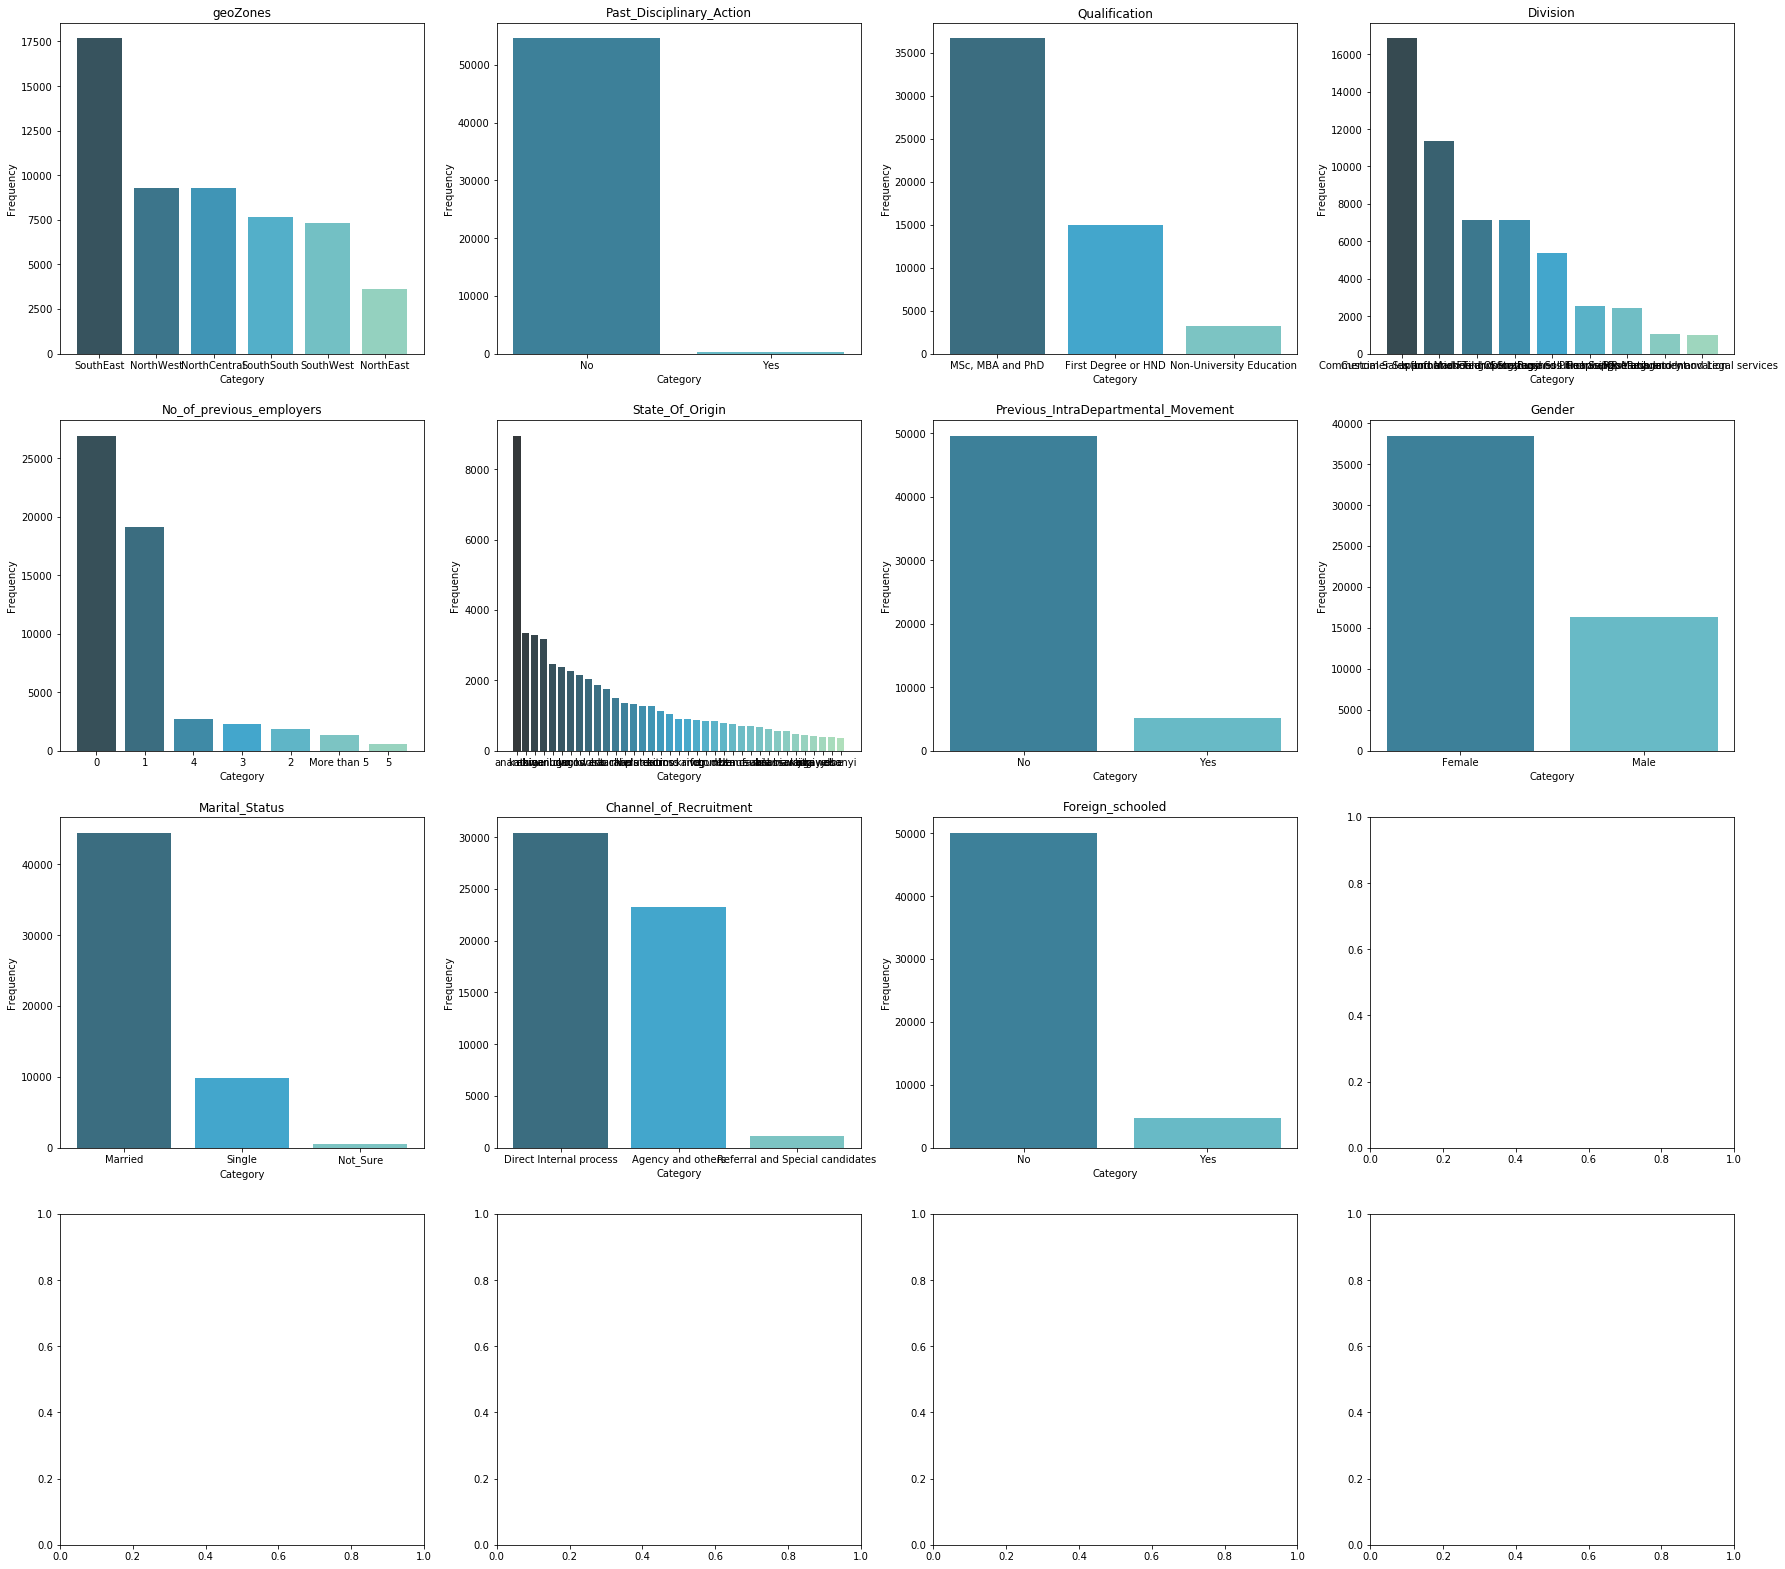

In [38]:
#Instantiate a 2x2 figure for the 4 plots.
fig, axs = plt.subplots(4, 4,figsize=(30,28))
#Create a bar chart for each of the non-numerical variables.
for i, col in enumerate(non_num_cols):
    #Helper variables to assign the correct axes to each of the 4 plots.
    j=i//4
    k=i%4
    #Setting a color palette for the plots.
    color = sns.color_palette("GnBu_d",n_colors=len(data[col].unique()))
    #Create the bar plot.
    axs[j,k].bar(data[col].astype('str').unique(), data[col].value_counts(), color= color)
    axs[j,k].set_title(col)
    axs[j,k].set_ylabel('Frequency')
    axs[j,k].set_xlabel('Category')
plt.show();

## One-hot-code categorical features

In [39]:
nonum_feats_names=  ['Division', 'Qualification', 'Gender', 'Channel_of_Recruitment', 'State_Of_Origin', 'Foreign_schooled',
             'Marital_Status', 'Past_Disciplinary_Action', 'Previous_IntraDepartmental_Movement',
             'No_of_previous_employers', 'Year_of_recruitment', 'Year_of_birth', 'Trainings_Attended','Last_performance_score', 
             'Previous_Award', 'Targets_met', 'is_Qualification_na', 'geoZones',]
num_cols_names= ['Training_score_average', 'employedAge']

In [40]:
#Assign appropriate data type to categorical variables.
nonum_feats = data[nonum_feats_names].astype('category')
nonum_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 18 columns):
Division                               54808 non-null category
Qualification                          54808 non-null category
Gender                                 54808 non-null category
Channel_of_Recruitment                 54808 non-null category
State_Of_Origin                        54808 non-null category
Foreign_schooled                       54808 non-null category
Marital_Status                         54808 non-null category
Past_Disciplinary_Action               54808 non-null category
Previous_IntraDepartmental_Movement    54808 non-null category
No_of_previous_employers               54808 non-null category
Year_of_recruitment                    54808 non-null category
Year_of_birth                          54808 non-null category
Trainings_Attended                     54808 non-null category
Last_performance_score                 54808 non-null category
Previous_

In [41]:
#One-hot-code categorical variables and dropping the reference value.
ohc_feats = pd.get_dummies(nonum_feats,drop_first=True)
ohc_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Columns: 164 entries, Division_Commercial Sales and Marketing to geoZones_SouthWest
dtypes: uint8(164)
memory usage: 8.6 MB


### 4.2 Plain Vanilla Classification Models

The classifiers that I will be testing are:
* Logistic Regression
+ Decision Tree
* Random Forest
* Gradient Boosting

In [42]:
target.value_counts()

0    35071
1     3241
Name: Promoted_or_Not, dtype: int64

In [43]:
target.count()

38312

In [44]:
ohc_data = pd.concat([data[num_cols_names], ohc_feats],axis=1)

train = ohc_data.iloc[0:38312]
test = ohc_data.iloc[38312:]

In [45]:
results1 = baseline_models(data=[train,target], verbose=True)

Classification Model:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best') 

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      8739
           1       0.44      0.45      0.44       839

    accuracy                           0.90      9578
   macro avg       0.69      0.70      0.69      9578
weighted avg       0.90      0.90      0.90      9578
 

Classification Model:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
      

In [46]:
#Display the results of the models as a dataframe
#Sort models according to f1 score.
results1.sort_values('f1',ascending=False)

,f1,roc_auc,accuracy,precision,recall
Gradient Boosting,0.474820,0.656815,0.939027,0.967033,0.314660
DecisionTree,0.442080,0.695479,0.901441,0.438453,0.445769
LogisticRegression,0.367006,0.615595,0.928691,0.825000,0.235995
RandomForest,0.299706,0.589521,0.925350,0.840659,0.182360


In [47]:
print('Best Model per Metric')
for metric in results1.columns:
    print(f'{metric.capitalize()}:',results1.sort_values(metric,ascending=False).index[0])

Best Model per Metric
F1: Gradient Boosting
Roc_auc: DecisionTree
Accuracy: Gradient Boosting
Precision: Gradient Boosting
Recall: DecisionTree


The Gradient Boosting Classifier is the best performing so far. Being this a binary classification problem with an imbalanced dataset, I am mostly concerned with the f1 and roc_auc scores.

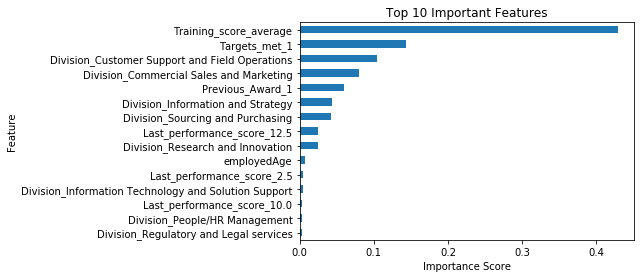

In [48]:
X_train, X_test, y_train, y_test = train_test_split(train,target,random_state=123)
clf = GradientBoostingClassifier()
clf.fit(X_train,y_train)
plot_feat_importance(clf, train.columns)

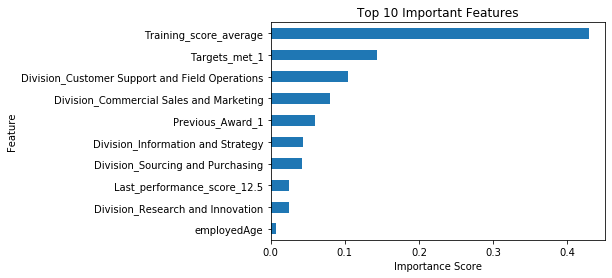

In [94]:
X_train, X_test, y_train, y_test = train_test_split(train,target,random_state=123)
clf = GradientBoostingClassifier()
clf.fit(X_train,y_train)
plot_feat_importance(clf, train.columns)

In [98]:
'''Scaling the data first fitting it and transforming the training set
to later aply the fit to transform the test set.'''
#Instantiate Satandard Scaler
scaler = StandardScaler()
#Fit transform the numerical features in the training dataset to a new dataframe
scaled_numfeats_train = pd.DataFrame(scaler.fit_transform(X_train[num_cols_names]), 
                                     columns=num_cols_names, index= X_train.index)
#Integrate scaled values to the training set
for col in num_cols_names:
    X_train[col] = scaled_numfeats_train[col]
#Transform the numerical features inthe training dataset to a new dataframe
scaled_numfeats_test = pd.DataFrame(scaler.transform(X_test[num_cols_names]),
                                    columns=num_cols_names, index= X_test.index)
#Integrate scaled values to the test set
for col in num_cols_names:
    X_test[col] = scaled_numfeats_test[col]

In [99]:
results3 = baseline_models(data=[X_train, X_test, y_train, y_test])
results3.sort_values('f1',ascending=False)

,f1,roc_auc,accuracy,precision,recall
Gradient Boosting,0.474820,0.656815,0.939027,0.967033,0.314660
DecisionTree,0.451765,0.701552,0.902694,0.445993,0.457688
LogisticRegression,0.400361,0.629554,0.930570,0.822222,0.264601
RandomForest,0.294758,0.587480,0.925559,0.866279,0.177592


The f1 scores of the baseline models improved by scaling the data. Especifically, gradient boosting saw the greatest performance increase from a little less than 63% to 67%. Now, in an effort to correct the imbalanced dataset I wil perform Synthetic Minority Over-sampling Technique to create synthetic data that helps the model balance the target incidence.

In [125]:
cat_col_index = list(range(len(num_cols_names),166))
sm = SMOTENC(categorical_features=cat_col_index, random_state=123, n_jobs=-1)
X_trainres, y_trainres = sm.fit_resample(X_train, y_train)

In [126]:
#Find out the new target incidency rate.
pd.DataFrame(y_trainres,columns=['outcome']).outcome.value_counts(normalize=False)

In [127]:
y_train.value_counts()

0    26332
1     2402
Name: Promoted_or_Not, dtype: int64

In [128]:
results4 = baseline_models(data=[X_trainres, X_test, y_trainres, y_test])
results4.sort_values('f1',ascending=False)

,f1,roc_auc,accuracy,precision,recall
DecisionTree,0.400883,0.681485,0.886720,0.373457,0.432658
LogisticRegression,0.385913,0.641801,0.912612,0.501908,0.313468
Gradient Boosting,0.356250,0.718297,0.806431,0.251347,0.611442
RandomForest,0.283881,0.592266,0.906766,0.433824,0.210965


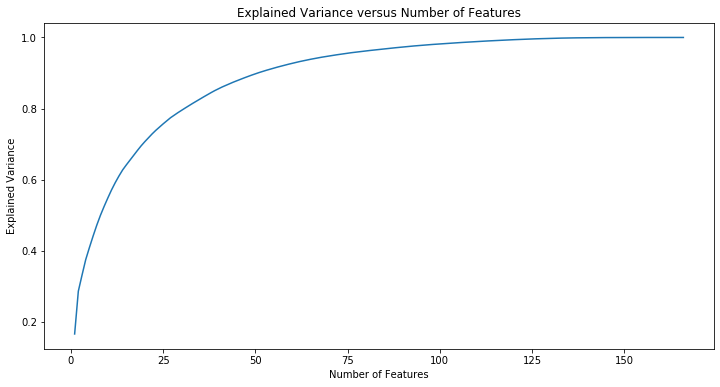

In [129]:
#Instantiate Principal Component Analysis.
pca=PCA()
X_pca = pca.fit_transform(X_trainres)
fig = plt.figure(figsize=(12,6))
plt.plot(range(1,X_trainres.shape[1]+1), pca.explained_variance_ratio_.cumsum())
plt.title('Explained Variance versus Number of Features')
plt.ylabel('Explained Variance')
plt.xlabel('Number of Features')
plt.show();

In [132]:
for n in [40,50,60,70]:
    pca_n = PCA(n_components=n)
    X_pcan = pca_n.fit_transform(X_trainres)
    tev = round(np.sum(pca_n.explained_variance_ratio_)*100,2)
    print('Number of Fetaures: ',n, 'Total Explained Variance: ',tev,'%')

Number of Fetaures:  40 Total Explained Variance:  85.55 %
Number of Fetaures:  50 Total Explained Variance:  89.76 %
Number of Fetaures:  60 Total Explained Variance:  92.72 %
Number of Fetaures:  70 Total Explained Variance:  94.78 %


In [144]:
#Create pipeline for each of the classifiers.
pipelines = {#'logisticregression': Pipeline([('pca', PCA()),
             #                               ('clf', LogisticRegression(random_state=123))]),
            #'decisiontree':Pipeline([('pca', PCA()),
             #                               ('clf', DecisionTreeClassifier(random_state=123))]),
            #'randomforest':Pipeline([('pca', PCA()),
             #                               ('clf', RandomForestClassifier(random_state=123))]),
            'gradientboosting': Pipeline([('pca', PCA()),
                                            ('clf', GradientBoostingClassifier(random_state=123))])}

#Define Hyperparameters for each pipeline
hyperparameters_lr ={'pca__n_components': [50,60,70],
                     'clf__C': [0.01,0.1,1]}

hyperparameters_dt ={'pca__n_components': [50,60,70],
                     'clf__criterion': ['entropy', 'gini'], 
                     'clf__max_depth': [4, 5, 6],  
                     'clf__min_samples_leaf':[0.05 ,0.1, 0.2],  
                     'clf__min_samples_split':[0.05 ,0.1, 0.2]}

hyperparameters_rf ={'pca__n_components': [50,60,70],
                     'clf__n_estimators': [100,150],
                     'clf__criterion': ['entropy', 'gini'], 
                     'clf__max_depth': [4, 5, 6],  
                     'clf__min_samples_leaf':[0.05 ,0.1, 0.2],  
                     'clf__min_samples_split':[0.05 ,0.1, 0.2]}

hyperparameters_gb ={'pca__n_components': [50,60,70],
                     'clf__n_estimators': [100,150], 
                     'clf__max_depth': [1, 3, 5],  
                     'clf__learning_rate': [0.05,0.1]}

#Instantiate hyperparapeter dictionary
hyperparameters = {#'logisticregression':hyperparameters_lr ,
                   #'decisiontree':hyperparameters_dt,
                   #'randomforest':hyperparameters_rf,
                   'gradientboosting': hyperparameters_gb}

In [145]:
model_scores_f1, fitted_models_f1 = grid_pipe(pipelines,hyperparameters,scoring='f1')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 111.2min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 144.2min finished


The gradientboosting model has been fitted.
Best accuracy: 0.929
Best params:
 {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 150, 'pca__n_components': 70} 



In [146]:
score_times_df_f1 = pd.DataFrame(model_scores_f1,
                              columns=['classifier','f1_score',
                                       'time']).set_index('classifier').sort_values('time')
score_times_df_f1

,f1_score,time
classifier,,
gradientboosting,0.928702,8874.696679


gradientboosting :


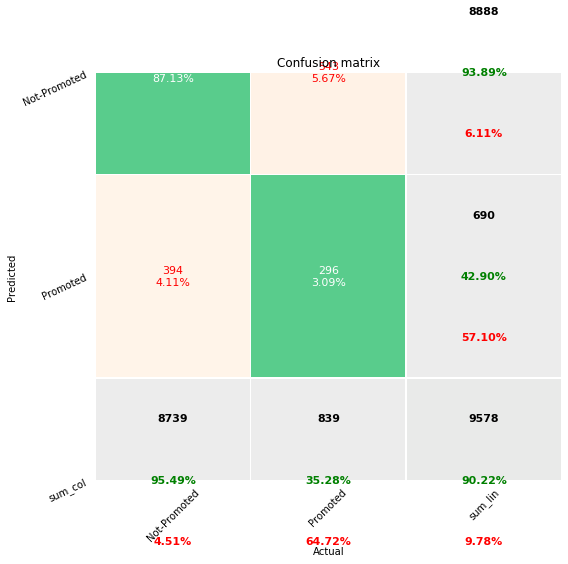

In [153]:
for name, model in fitted_models_f1.items():
    if name in ['gradientboosting']:
        pred = model.predict(X_test)
        print(name,':')
        plot_confusion_matrix_from_data(y_test,pred,columns=['Not-Promoted','Promoted'], cmap='Oranges')

In [154]:
fitted_models_f1['gradientboosting'].best_params_

{'clf__learning_rate': 0.1,
 'clf__max_depth': 5,
 'clf__n_estimators': 150,
 'pca__n_components': 70}

In [155]:
cat_col_index = list(range(len(num_cols_names),166))
sm = SMOTENC(categorical_features=cat_col_index, random_state=123, n_jobs=-1)
X_trainf, y_trainf = sm.fit_resample(train, target)

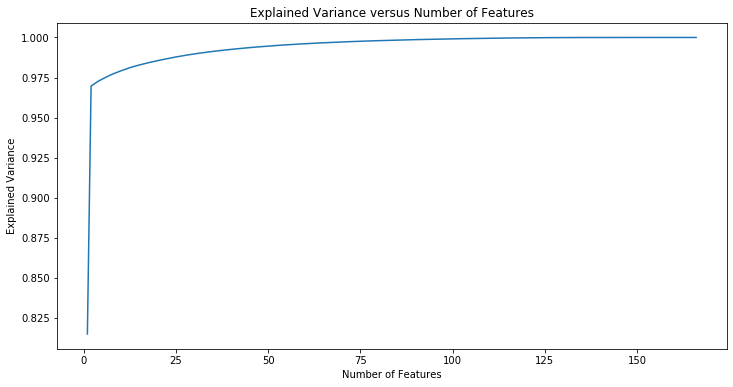

In [186]:
#Instantiate Principal Component Analysis.
#pca=PCA()
X_pcaf = pca.fit_transform(train)
fig = plt.figure(figsize=(12,6))
plt.plot(range(1,train.shape[1]+1), pca.explained_variance_ratio_.cumsum())
plt.title('Explained Variance versus Number of Features')
plt.ylabel('Explained Variance')
plt.xlabel('Number of Features')
plt.show();

In [211]:
for n in [10,20,30,40,50,60,70, 80,90,100]:
    pca_fn = PCA(n_components=n)
    X_pcafn = pca_fn.fit_transform(train)
    test_pcafn = pca_fn.fit_transform(test)
    tev = round(np.sum(pca_fn.explained_variance_ratio_)*100,2)
    print('Number of Fetaures: ',n, 'Total Explained Variance: ',tev,'%')

Number of Fetaures:  10 Total Explained Variance:  97.93 %
Number of Fetaures:  20 Total Explained Variance:  98.57 %
Number of Fetaures:  30 Total Explained Variance:  98.98 %
Number of Fetaures:  40 Total Explained Variance:  99.26 %
Number of Fetaures:  50 Total Explained Variance:  99.46 %
Number of Fetaures:  60 Total Explained Variance:  99.61 %
Number of Fetaures:  70 Total Explained Variance:  99.72 %
Number of Fetaures:  80 Total Explained Variance:  99.8 %
Number of Fetaures:  90 Total Explained Variance:  99.86 %
Number of Fetaures:  100 Total Explained Variance:  99.91 %


In [200]:
pca_fn = PCA(n_components=70)
X_pcafn = pca_fn.fit_transform(train)
test_pcafn = pca_fn.fit_transform(test)
y_trainf;

In [214]:
model = GradientBoostingClassifier(random_state=123, n_estimators=500, max_depth=15,
                                   learning_rate=0.1)

In [215]:
model.fit(X_pcafn,target)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=15,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='auto',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [216]:
labels= model.predict(test_pcafn)

In [217]:
submission = pd.DataFrame({'EmployeeNo': test_id, 'Promoted_or_Not': labels})

In [218]:
submission.Promoted_or_Not.unique()

array([0, 1], dtype=int64)

In [219]:
submission.head(5)

,EmployeeNo,Promoted_or_Not
0,YAK/S/00005,0
1,YAK/S/00011,0
2,YAK/S/00015,0
3,YAK/S/00016,0
4,YAK/S/00017,0


In [220]:
sampleSub = sampleSubmission.EmployeeNo.iloc[0:]
indexSub= submission.set_index('EmployeeNo')
submit= indexSub.reindex(sampleSub)
submit.tail()

,Promoted_or_Not
EmployeeNo,
YAK/S/36027,0
YAK/S/40875,0
YAK/S/44292,0
YAK/S/14610,0
YAK/S/13971,0


In [221]:
submit.to_csv('submission4a.csv', index=True)
submit.Promoted_or_Not.unique()

array([0, 1], dtype=int64)

In [222]:
submit.count()

Promoted_or_Not    16496
dtype: int64

## TRY ENTITY EMBEDDINGS

In [123]:
train= pd.read_csv('train.csv')
test= pd.read_csv('test.csv')
sampleSubmission= pd.read_csv('sample_submission2.csv')

In [124]:
test_id = test['EmployeeNo'] 

In [125]:
pd.set_option('display.max_columns', None)

In [126]:
#Merge both train and test data
df = train.append(test, sort=False, ignore_index=True)

In [127]:
train.iloc[0:38312];


In [128]:
train.columns

Index(['EmployeeNo', 'Division', 'Qualification', 'Gender',
       'Channel_of_Recruitment', 'Trainings_Attended', 'Year_of_birth',
       'Last_performance_score', 'Year_of_recruitment', 'Targets_met',
       'Previous_Award', 'Training_score_average', 'State_Of_Origin',
       'Foreign_schooled', 'Marital_Status', 'Past_Disciplinary_Action',
       'Previous_IntraDepartmental_Movement', 'No_of_previous_employers',
       'Promoted_or_Not'],
      dtype='object')

In [129]:
df['employedAge'] = df.Year_of_recruitment - df.Year_of_birth



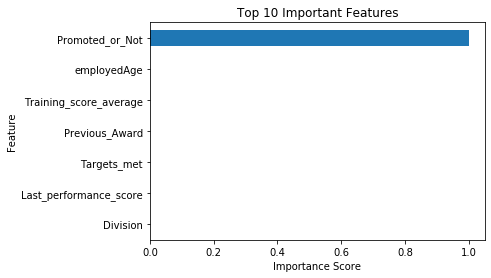

In [146]:
X_train, X_test, y_train, y_test = train_test_split(train,target,random_state=123)
clf = GradientBoostingClassifier()
clf.fit(X_train,y_train)
plot_feat_importance(clf, train.columns)

In [130]:
#following the feature importance, we will drop the less important columns

df = df.drop(['Qualification'], axis = 1)
df = df.drop(['Gender'], axis = 1)
df = df.drop(['Channel_of_Recruitment'], axis = 1)
df = df.drop(['Trainings_Attended'], axis = 1)
df = df.drop(['Year_of_birth'], axis = 1)
df = df.drop(['Marital_Status'], axis = 1)
df = df.drop(['State_Of_Origin'], axis = 1)
df = df.drop(['No_of_previous_employers'], axis = 1)
df = df.drop(['Previous_IntraDepartmental_Movement'], axis = 1)
df = df.drop(['Past_Disciplinary_Action'], axis = 1)
df = df.drop(['Foreign_schooled'], axis = 1)
df = df.drop(['Year_of_recruitment'], axis = 1)
df = df.drop(['EmployeeNo'], axis = 1)

In [131]:
#path = untar_data(train)

path = Path('Users/ANTHONY-PC/01workspace/dsn Challenge')

In [132]:
df['Division'] = df['Division'] .astype("category").cat.codes
df['Last_performance_score'] = df['Last_performance_score'] .astype("category").cat.codes

In [133]:
train = df.iloc[0:38312]
test = df.iloc[38312:]

train.Promoted_or_Not=train.Promoted_or_Not.astype(int)
test = test.drop(['Promoted_or_Not'], axis = 1)

In [134]:
train.head()

,Division,Last_performance_score,Targets_met,Previous_Award,Training_score_average,Promoted_or_Not,employedAge
0,1,5,1,0,41,0,25
1,2,5,0,0,52,0,24
2,1,3,0,0,42,0,25
3,1,1,0,0,42,0,27
4,4,3,0,0,77,0,22


In [135]:
dep_var= ['Promoted_or_Not']
cat_names=  ['Division','Last_performance_score']
cont_names= ['Targets_met', 
             'Previous_Award', 'Training_score_average', 'employedAge']
procs = [Categorify, Normalize]

In [136]:
tests = TabularList.from_df(test, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)

In [137]:
data = (TabularList.from_df(train, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_rand_pct(valid_pct=0.02, seed=123) #.split_none()
                           .label_from_df(cols=dep_var)
                           .add_test(tests)
                           .databunch(num_workers=0)) 

In [138]:
data.show_batch(rows=5)

Division,Last_performance_score,Targets_met,Previous_Award,Training_score_average,employedAge,target
4,4,1.3528,-0.1538,1.3927,-0.5022,1
1,5,1.3528,-0.1538,-1.0757,-0.3307,0
8,3,-0.7392,-0.1538,0.6447,-0.6736,0
2,3,-0.7392,-0.1538,-0.5521,0.3549,0
8,4,-0.7392,-0.1538,0.3455,0.0121,0


In [142]:
#
learn = tabular_learner(data, layers=[200,10] ,metrics=[accuracy],ps=[0.04,0.07], callback_fns=ShowGraph) #ps=[0.001,0.01],emb_drop=0.09,

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


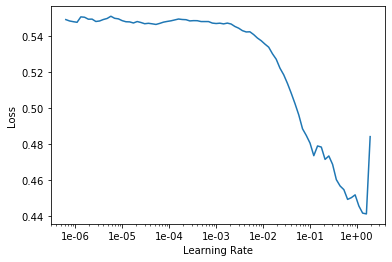

In [143]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.496732,0.493133,0.886423,00:08
1,0.351749,0.328851,0.924282,00:08
2,0.196923,0.185000,0.941253,00:09
3,0.177575,0.182145,0.939948,00:08
4,0.179673,0.182204,0.932115,00:09
5,0.176253,0.171861,0.941253,00:11
6,0.170191,0.167120,0.945170,00:09
7,0.179520,0.164298,0.946475,00:10
8,0.182262,0.161653,0.943864,00:10
9,0.179413,0.160107,0.942559,00:10


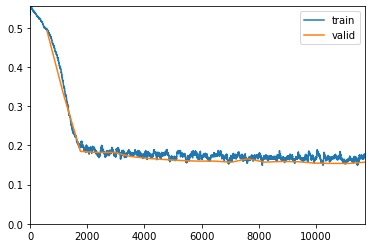

In [144]:
#learn.fit(8, 1e-2)
learn.fit_one_cycle(20, 1e-3)

In [106]:
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)

In [107]:
submission = pd.DataFrame({'EmployeeNo': test_id, 'Promoted_or_Not': labels})

In [108]:
# Rearrangew to Submission.csv
 


sampleSub = sampleSubmission.EmployeeNo.iloc[0:]
indexSub= submission.set_index('EmployeeNo')
submit= indexSub.reindex(sampleSub)
submit.tail()

,Promoted_or_Not
EmployeeNo,
YAK/S/36027,0
YAK/S/40875,0
YAK/S/44292,0
YAK/S/14610,0
YAK/S/13971,0


In [109]:
submit.to_csv('submission30i.csv', index=True)